In [1]:
import numpy as np
import pandas as pd
import scipy.misc
import pywt
from pywt import cwt
import matplotlib.pyplot as plt
import cv2 as cv
import os
from PIL import Image

In [2]:
def readECG():
    """
    reads the ECGdata and ECGlabels, which are CSV files that should be
    in ./ECGdata directory.
    
    Returns
    -------
    ECGdata:
            np.2darray - the ECG signals.
            shaped (number_of_ECG_signals,number_of_samples_of each signal)
    ECGdata:
            np.1darray of strings - the labels. 
    """
    ECGdata = pd.read_csv(os.path.join("." ,"ECGdata", "data.csv"), header=None)
    ECGlabels = pd.read_csv(os.path.join("." ,"ECGdata", "labels.csv"), header=None)
    ECGdata = ECGdata.to_numpy()
    ECGlabels = np.squeeze(ECGlabels.to_numpy())
    print ('ECGdata: ' , type(ECGdata) , '\n' , 'shape: ' , ECGdata.shape)
    print ('ECGlabels: ' ,  type(ECGlabels) , '\n' , 'shape: ' , ECGlabels.shape)
    return ECGdata, ECGlabels

In [3]:
def plotSignals(time_to_plot,Fs,data, labels,NSR_index = 150, ARR_index = 0, CHF_index = 98):
    """
    gets the ECG matrix and the labels, one index of every class, and prints
    signal of each class to the screen.

    Parameters
    ----------
    time_to_plot: 
        double, the desired signal length(in time) to plot.
        the plot will start at t = 0 and will end at t = time_to_plot
    
    data:
        np.2darray - the ECG signals.
        shaped (number_of_ECG_signals,number_of_samples_of each signal)
    Fs:
        double, sampling frequency of the ECG signals
    labels:
        np.1darray of strings - the labels.
    NSR_index:
            int, index of an NSR patient
    ARR_index:
            int, index of an ARR patient
    CHF_index:
            int, index of an CHF patient
    """    
    
    assert (labels[NSR_index] == 'NSR' and labels[CHF_index] == 'CHF' and labels[ARR_index] == 'ARR')
    samples_number = int (time_to_plot * Fs)
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(30, 6))
    fig.suptitle('ECG signals', size = 'xx-large', color = 'teal')
    t = np.linspace (0,time_to_plot,num = samples_number)
    plotAx(ax1, t, data[NSR_index,:samples_number], labels[NSR_index])
    plotAx(ax2, t,  data[ARR_index,:samples_number], labels[ARR_index])
    plotAx(ax3, t, data[CHF_index,:samples_number], labels[CHF_index])

In [4]:
def plotAx(ax,t,sig,description):
    """
        helper function to plotSignals
    """
    ax.plot(t, sig)
    ax.set_xlabel('time [sec]', size = 'xx-large')
    ax.set_ylabel('volatage [mV]', size = 'large')
    ax.grid()
    ax.set_title(description, color = 'deeppink', size = 'x-large')

In [5]:
def createDirectories():
    """
        after calling to this function, the directory contains the code.py file will have in it a
        directory named 'data' and in 'data' three sub directories : 'ARR' ,'CHF' and 'NSR'
        
        returns:
        a dictionary 'dir_path' with labels names as keys, and path to the relevant directory from the
        directory that contains the code.py file.

    """
    
    #create the data directory if does not exists alredy
    data_dir_path = "./data"
    if not os.path.exists(data_dir_path):
        os.mkdir(data_dir_path)
          
    #dictinary where the keys are the labels names and values are boolian: directory of this label exists / does not exists
    existsDirectory = {
        "ARR": os.path.exists(os.path.join(data_dir_path, "ARR")),
        "CHF": os.path.exists(os.path.join(data_dir_path, "CHF")),
        "NSR": os.path.exists(os.path.join(data_dir_path, "NSR")),
    }
    
    #dictinary where the keys are the labels names and values are the corresponding directory path
    dir_path = {
        "ARR": os.path.join(data_dir_path, "ARR"),
        "CHF": os.path.join(data_dir_path, "CHF"),
        "NSR": os.path.join(data_dir_path, "NSR")
    }
    
    #create the sub directories that do not exists alredy

    for dir_name in existsDirectory:
        if existsDirectory[dir_name] == False: 
            os.mkdir(dir_path[dir_name])
            
            
    return dir_path

In [6]:
def computeScalesNum(voices_per_octave,fmin,fmax):
    """
    used only in the case we compute cwt with log scales
    gets minimum and maximum frequencies, in Herz, to use in the cwt, and the frequency resolution of the grid

    Parameters
    ----------
    voices_per_octave :
            int, specifies the number of wavelet scales that are used per octave.
            determines the resolution of the wavelet transform in the frequency axis. 

    fmin:
            double, speifies the lower boundary,in Herz, of the frequency axis of the cwt.
    fmax:
            double, speifies the upper boundary,in Herz, of the frequency axis of the cwt.

    Returns
    -------
    start:
            double, log10(fmax)
    stop:
            double, log10(fmin)
    num:
            int, number of scales , meaning the number of rows in the grid of the cwt. 
    """
    
    start = np.log10(fmax)
    stop = np.log10(fmin)
    number_of_decades = start - stop 
    number_of_octaves = np.log2(pow(10,number_of_decades))
    num = int(voices_per_octave * number_of_octaves)
    return start, stop, num

In [7]:
def cutSignal(signal,start_time,stop_time,Fs):
    first_sample = int (Fs * start_time) 
    last_sample = int (Fs * stop_time) 
    return signal[first_sample:last_sample]

In [8]:
def computeCwt(signal,start_time, stop_time ,B ,C ,voices_per_octave ,fmin,fmax, Fs ,scales_type):
    """
    gets a signal and parameters, and computes the signal continius wavelet transform
    uses a complex morlet as a mother wavelet and returns the absoulue value of the coefficients.
    
    Parameters
    ----------
    
    signal:
        np.1darray
      
    B :
        int, bandwith of the complex morlet

    C:  
        int, centeral frequency of the complex morlet
            
    voices_per_octave :
            only used when scaled type is 'log'
            int, specifies the number of wavelet scales that are used per octave.
            determines the resolution of the wavelet transform in the frequency axis. 
    
    fmin:
        double, speifies the lower boundary,in Herz, of the frequency axis of the cwt.
    fmax:
        double, speifies the upper boundary,in Herz, of the frequency axis of the cwt.
    Fs : 
        double, the sampling frequency

    Returns
    -------
    
    coef_abs :
        np.2darray of real numbers shaped (len(signal), voices_per_octave * num) - to understand num see computeScalesNum
        absoulute value of cwt(signal)
    """
    assert (scales_type in ('log', 'linear'))
    signal = cutSignal(signal,start_time,stop_time,Fs) 
    if scales_type == 'log':
        start, stop, num = computeScalesNum(voices_per_octave,fmin,fmax)
        scales = np.logspace(start,stop,num = num)
    elif scales_type == 'linear':
        scales = np.arange(fmin, fmax)
    wavelet = f'cmor{B}-{C}'
    coef, _ = cwt(signal, scales, wavelet)
    coef_abs = np.abs(coef)
    return coef_abs

In [9]:
def getRGB_224_224_3(coef_abs):
    """
    gets coefficients matrix , uses a cmap and returns 224 X 224 X 3 RGB image 
    
    Parameters
    ----------
    coef_abs : np.2darray of real numbers, the cwt coefs absoulute value  
    

    Returns
    -------
    
    RGB_224_224_3 : np.3darray of uint8 shaped (224,224,3)        
    """
    cmap = plt.get_cmap('jet')

    # Normalize the cwt array to the range [0, 1]
    cwt_normalized = (coef_abs - coef_abs.min()) / (coef_abs.max() - coef_abs.min())

    # Create an RGB image using the cmap and the normalized cwt array
    rgb_image = cmap(cwt_normalized)
    rgb_image = np.delete(rgb_image, 3, 2)
    rgb_image = (rgb_image * 255).astype('uint8')
    # Resize the image to 224 x 224
    resized_image = cv.resize(rgb_image, (224, 224))
    resized_image = cv.cvtColor(resized_image, cv.COLOR_BGR2RGB)
    RGB_224_224_3 = resized_image
    return RGB_224_224_3

In [10]:
def showScalogram(abs_cwtmatr,start_time,stop_time):
    plt.matshow(abs_cwtmatr, extent=[start_time, stop_time, 0, 64], 
               cmap='jet', aspect='auto')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('ECG CWT Scalogram')
    plt.show()

In [11]:
def writeScalogramToDir(rgb_scalogram,labels,dir_path,index):
    """
        helper function to createScalogramsAndWriteToDir

    """
    output_path = os.path.join(dir_path[labels[index]], labels[index] + '_' + str(index) + '.jpg')
    cv.imwrite(output_path, rgb_scalogram)

In [12]:
def createScalogramsAndWriteToDir(data,labels,start_time, stop_time, computation = 'linear' , voices_per_octave = 12, fmin = 1, fmax = 64, B = 1.5, C = 2):
    """
    create a directory for each label,
    gets the ECG signals and parameters, compute each signal cwt,converts the resulted scalogram to 
    a 224 X 224 X 3 RGB image, and writes the image to the directory associated to the ECG signal label . 
    
    Parameters
    ----------
    
    data:
            np.2darray - the ECG signals.
            shaped (number_of_ECG_signals,number_of_samples_of each signal)
    labels:
            np.1darray of strings - the labels.
            
    voices_per_octave :
            int, specifies the number of wavelet scales that are used per octave.
            determines the resolution of the wavelet transform in the frequency axis.
    fmin:
            double, speifies the lower boundary,in Herz, of the frequency axis of the cwt.
    fmax:
            double, speifies the upper boundary,in Herz, of the frequency axis of the cwt.
      
    B :
        int, bandwith of the complex morlet

    C:  
        int, centeral frequency of the complex morlet
    """
    dir_path = createDirectories()    
    for i in range(len(labels)):
        signal = data[i, :]
        coef_abs = computeCwt(signal,start_time, stop_time ,B ,C ,voices_per_octave ,fmin,fmax, Fs ,computation)
        if (i == 98):
            showScalogram(coef_abs,start_time,stop_time)
        rgb_scalogram = getRGB_224_224_3(coef_abs)
        writeScalogramToDir(rgb_scalogram,labels,dir_path,i)

## main

In [13]:
ECGdata, ECGlabels = readECG () 

ECGdata:  <class 'numpy.ndarray'> 
 shape:  (162, 65536)
ECGlabels:  <class 'numpy.ndarray'> 
 shape:  (162,)


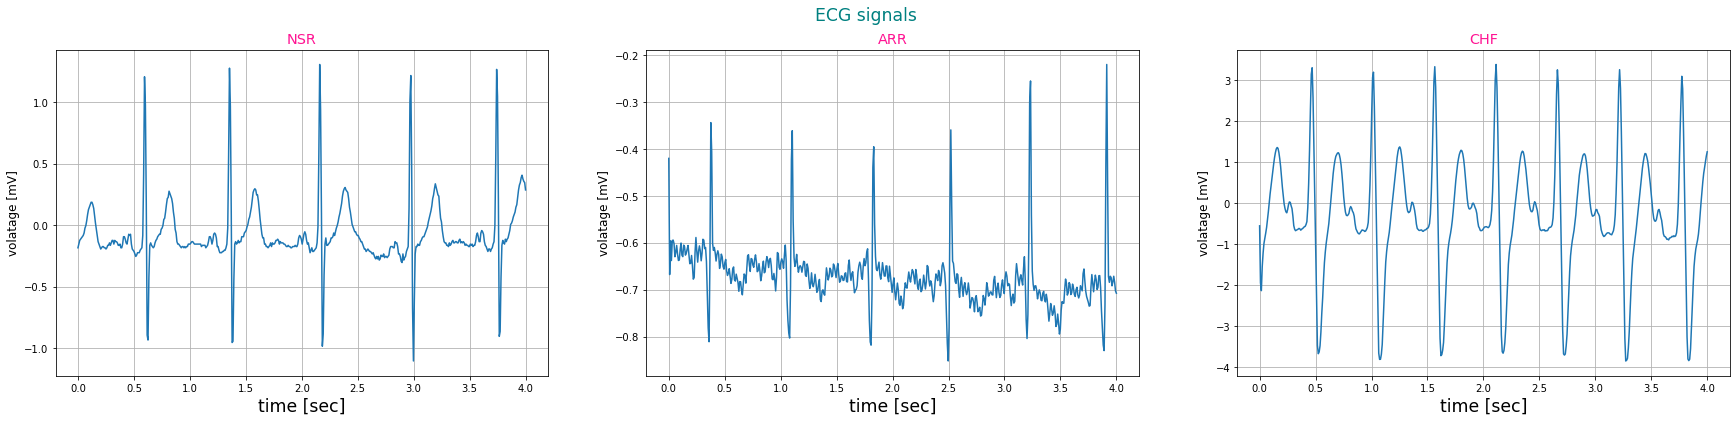

In [14]:
Fs = 128
plotSignals(4,Fs,ECGdata,ECGlabels,ARR_index = 56)

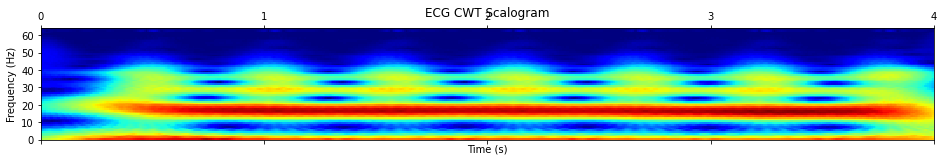

In [15]:
createScalogramsAndWriteToDir(ECGdata,ECGlabels,start_time = 0, stop_time = 4, B = 1.5,C = 2,computation = 'linear')